In [1]:
import numpy as np
import cvxpy as cp
import qutip as qt
from qutip import wigner, fock, Qobj, displace, destroy, tensor, qeye, coherent, ket2dm, expect, fidelity, fock_dm, ptrace
from qutip.visualization import plot_wigner_fock_distribution, plot_wigner, matrix_histogram, matrix_histogram_complex
from qutip.wigner import wigner
from scipy.special import genlaguerre
from math import sqrt, factorial
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd
from scipy.sparse.linalg import LinearOperator, lsqr
from tqdm.auto import tqdm # progress bar
from matplotlib import colors
from tcsim.visualization import*
from tcsim.gates import*
from tcsim.system import*
from tcsim.analyze.dataloader import*
from scipy.optimize import curve_fit
import h5py
from numpy import ma

def vectorize(rho):
    """
    Turn hermitian matrix rho into a real vector
    vectorize(rho)[:d] = diag(rho)
    vectorize(rho)[d:d + d*(d-1)/2] = Re[upper_triangle(rho)]
    vectorize(rho)[d + d*(d-1)/2:]  = Im[upper_triangle(rho)]
    """
    d = rho.shape[0]  ## the shape of first column - dimension of matrix, e.g. 3x3 matrix d = 3
    n_offd = d*(d-1)//2 
    ret = np.zeros(d**2) #array of zeros with dimensionality d**2
    i = 0
    for m in range(d):
        ret[m] = rho[m, m].real #mth entry in ret is real part of (m,m) diagonal entry of matrix, capped at d
        for n in range(m+1, d):
            ret[d+i] = rho[m, n].real  #set d+ith entry in ret to real part of (m,n) off diagonal entry of matrix
            ret[d+n_offd+i] = rho[m, n].imag
            i += 1
    return ret


def matricize(rvec):
    """
    Invert the vectorize operation such that matricize(vectorize(rho)) == rho
    """
    d = int(np.sqrt(len(rvec)))
    n_offd = d*(d-1)//2
    ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示
    i = 0
    for m in range(d):
        for n in range(m+1, d):
            real = rvec[d+i]
            imag = rvec[d+n_offd+i]
            val = real + 1j*imag
            ret[m, n] = val
            ret[n, m] = val.conj()
            i += 1
            
def char_ops(hilbert_size, betas):
    ops_list = []

    for beta in tqdm(betas):
        D = displace(100, beta) # need the larger Hilbert space to not get erroneous operators for large beta
        op = D
        op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        ops_list.append(op)

    return ops_list

def reconstruct_char_complex_convex(char, disps, dim):
    # construct vectors
    basis_vectors = []
    for i in range(dim):
        vector = fock(dim, i)
        basis_vectors.append(vector.full())

    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector2, vector1)
            basis_dms.append(dm)
    Pis = char_ops(dim, disps)
    A = np.zeros((len(Pis), dim*dim), dtype=complex)
    
    for index, a in tqdm(np.ndenumerate(A)):
        A[index] = np.trace(Pis[index[0]].full() @ basis_dms[index[1]])
    
    X = cp.Variable((dim,dim), hermitian=True)
    cost = cp.norm(A @ cp.reshape(X, (dim*dim)) - char, 2)

    constraints = [cp.trace(X) == 1, X >> 0]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    reconstructed_rho = Qobj(X.value)
    return reconstructed_rho

def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (X + Y*1j).flatten()


def squeezingStateThreeStep(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    u_3 = uvs[4]
    v_3 = uvs[5]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_2)*U_ideal_operator(u_2)*psi1
    psi3 = V_ideal_operator(v_3)*U_ideal_operator(u_3)*psi2
 
    return psi3

def reconstruct_dm(data,x, N):
    
    im = np.zeros((data.shape))
    data_with_im = data + 1j*im
    re_rho = reconstruct_char_complex_convex((data_with_im).flatten(),make_disps(np.max(x)*3,len(x)), N)
    rho = Qobj(re_rho)
    return rho


c:\Users\jonat\AppData\Local\pypoetry\Cache\virtualenvs\tcsim-vg60nFMD-py3.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## squeezed odd cat

[ 3.07563885e+02 -6.02704214e-02]


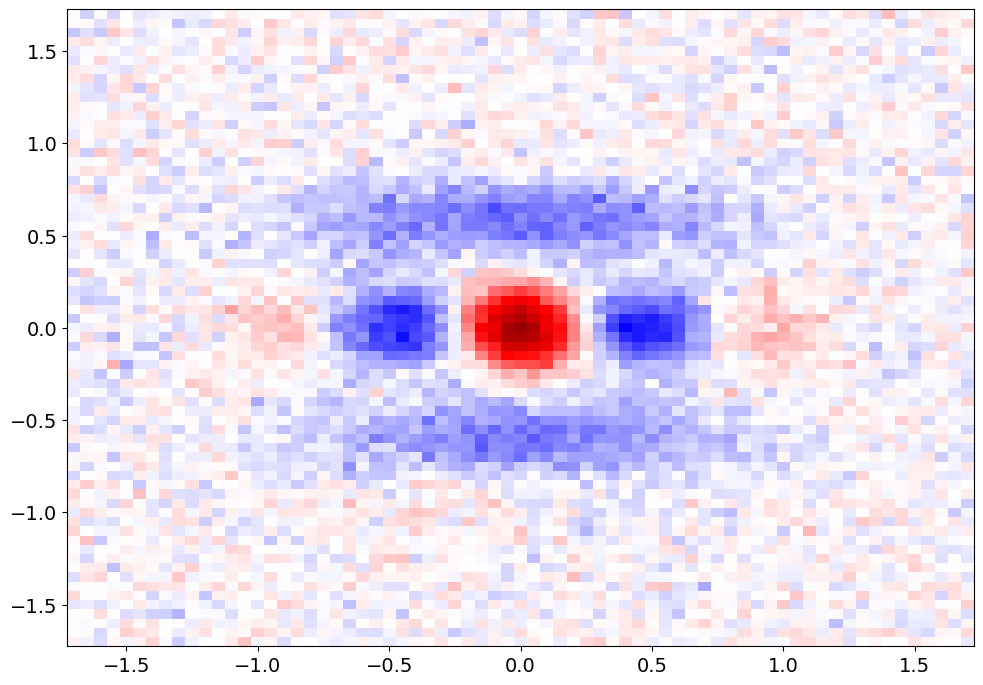

In [2]:
from scipy.optimize import curve_fit


path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig3/fig3_sq_vcat_6db_oddcat/"
file_end = 'panther_sq_vcat_6db_oddcat.h5'

thresholds = np.linspace(0,2e-4, 20)
floor_values = []
for threshold in thresholds:
    x, y, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=threshold, plot=False)
    floor_values.append(data_array[0][0:5,:].mean())

from scipy.optimize import curve_fit

def line(x, m, y):
    return x*m+y
popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
# plt.plot(thresholds,line(np.array(thresholds),*popt))
# plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])

xvec, yvec, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=thresh, plot=False)

#xvec = np.linspace(-1.7, 1.7, 69)
plt.pcolormesh(x,x,data_array[0],vmin = -1, vmax = 1, cmap="seismic")

100%|██████████| 4761/4761 [01:03<00:00, 75.54it/s]
1904400it [00:33, 56335.15it/s]


0.44881443884303995
0.4780335153189149
0.5035301271990342
0.5241552337383006
0.5389231019509055
0.5470510716764428
0.5479981617809093
0.5415102227477424
0.5276681076594797
0.506923050296132


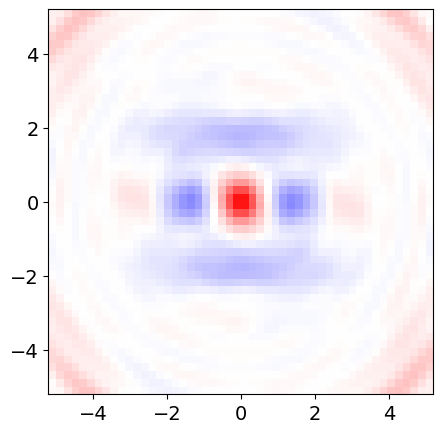

In [3]:
N = 20
vac_norm = 1

re_rho = reconstruct_dm(data_array[0]/vac_norm, x, N)
rho_tensor = tensor(qt.fock(2,0)*qt.fock(2,0).dag(),re_rho) 
plot_char(rho_tensor,max_alpha = 5.1)

uv = [1.62946677,  0.39181981, -0.48019506, -1.04030892, -1.10939512,0.32484321]
squeezed_vac = ptrace(squeezingStateThreeStep(uv),1)

alphas = np.linspace(0.7,1.1, 10)
cats = []
for  alpha in alphas:
    cat = ((displace(N,1j*alpha) - displace(N, -1j*alpha))*squeezed_vac*(displace(N,1j*alpha) - displace(N, -1j*alpha)).dag()).unit()
    cats.append(cat)

for cat in cats:
    print(expect(cat,re_rho))

In [4]:
N = 20
vac_norm = 0.884

re_rho = reconstruct_dm(data_array[0]/np.max(data_array[0]), x, N)
rho_tensor = tensor(qt.fock(2,0)*qt.fock(2,0).dag(),re_rho) 

for cat in cats:
    print(expect(cat,re_rho))

100%|██████████| 4761/4761 [01:02<00:00, 75.62it/s]
1904400it [00:45, 42156.85it/s]


0.4913200937837093
0.5237428387423465
0.5520301153646949
0.5749095637112926
0.5912906359800404
0.6003076961699311
0.6013617889222455
0.5941699436160859
0.5788183849169823
0.5558022841320469


[ 2.78640368e+02 -7.34386256e-02]


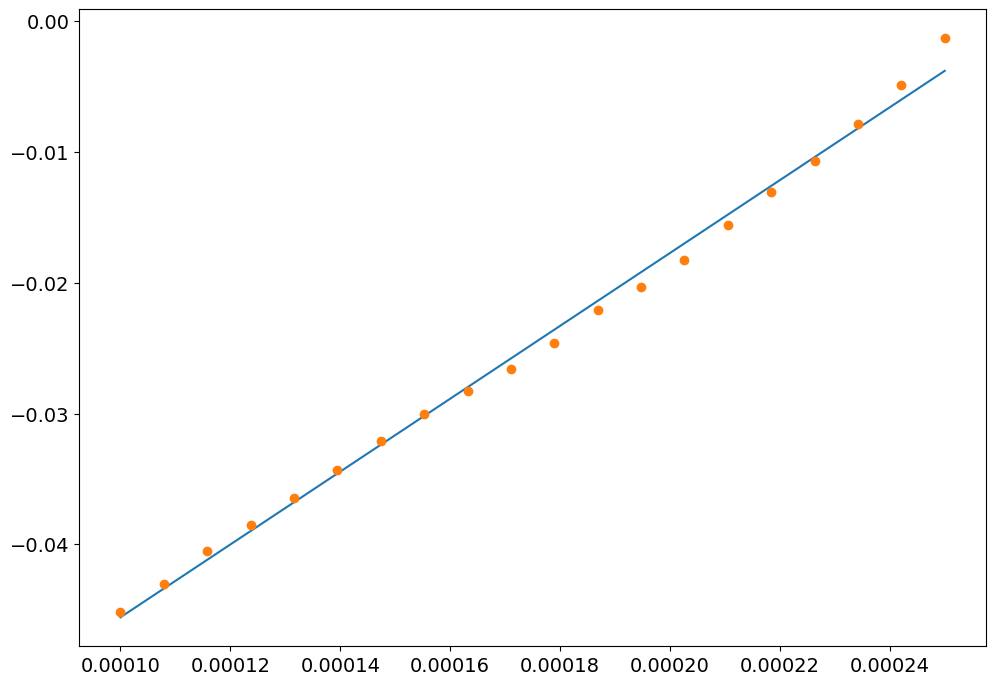

In [26]:
from scipy.optimize import curve_fit


path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig3/fig3_sq_vcat_6db_evencat/"
file_end = 'panther_sq_vcat_6db_evencat.h5'

thresholds = np.linspace(1e-4,2.5e-4, 20)
floor_values = []
for threshold in thresholds:
    x, y, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=threshold, plot=False)
    floor_values.append(data_array[0][0:5,:].mean())

from scipy.optimize import curve_fit

def line(x, m, y):
    return x*m+y
popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])

xvec, yvec, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=thresh, plot=False)

#xvec = np.linspace(-1.7, 1.7, 69)
#plt.pcolormesh(x,x,data_array[0],vmin = -1, vmax = 1, cmap="seismic")

100%|██████████| 4761/4761 [00:48<00:00, 97.88it/s] 
2975625it [01:00, 48818.52it/s]


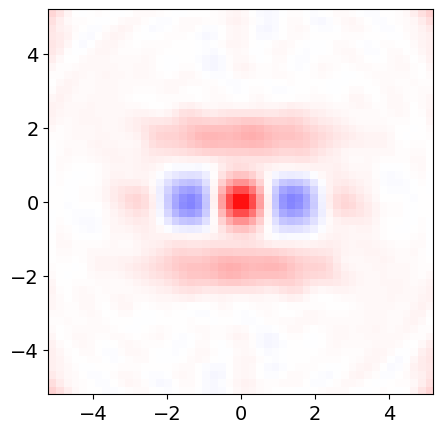

In [27]:
N = 25
vac_norm = 0.884

re_rho = reconstruct_dm(data_array[0]/vac_norm, x, N)
rho_tensor = tensor(qt.fock(2,0)*qt.fock(2,0).dag(),re_rho) 
plot_char(rho_tensor,max_alpha = 5.1)

In [30]:
uv = [1.62946677,  0.39181981, -0.48019506, -1.04030892, -1.10939512,0.32484321]
squeezed_vac = ptrace(squeezingStateThreeStep(uv),1)

alphas = np.linspace(0.7,1.1, 10)
cats = []
for  alpha in alphas:
    cat = ((displace(N,1j*alpha) + displace(N, -1j*alpha))*squeezed_vac*(displace(N,1j*alpha) + displace(N, -1j*alpha)).dag()).unit()
    cats.append(cat)

for cat in cats:
    print(expect(cat,re_rho))

0.4822883247856729
0.5200024770378526
0.5517028713201968
0.5762123709301088
0.5926901080143824
0.6007013129642145
0.6002475187922414
0.5917411695516362
0.5759297934204972
0.5537913378288518


# odd cat


[ 3.01080059e+02 -6.51458549e-02]


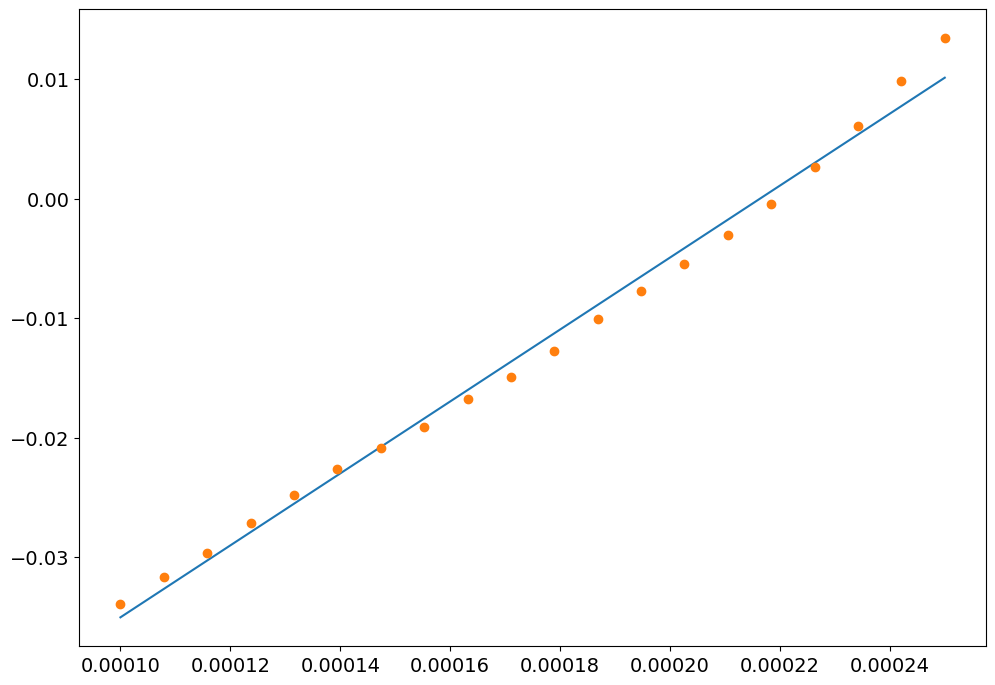

In [31]:
from scipy.optimize import curve_fit


path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig3/fig3_normal_oddcat/"
file_end = 'panther_normal_cat_decay_loop_oddcat.h5'

thresholds = np.linspace(1e-4,2.5e-4, 20)
floor_values = []
for threshold in thresholds:
    x, y, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=threshold, plot=False)
    floor_values.append(data_array[0][0:5,:].mean())

from scipy.optimize import curve_fit

def line(x, m, y):
    return x*m+y
popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])

xvec, yvec, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=thresh, plot=False)

#xvec = np.linspace(-1.7, 1.7, 69)
#plt.pcolormesh(x,x,data_array[0],vmin = -1, vmax = 1, cmap="seismic")

100%|██████████| 4761/4761 [00:53<00:00, 88.57it/s] 
2975625it [00:56, 52893.67it/s]


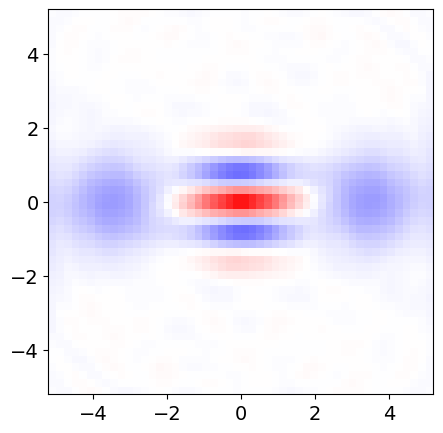

In [32]:
N = 25
vac_norm = 0.884
re_rho = reconstruct_dm(data_array[0]/vac_norm, x, N)
rho_tensor = tensor(qt.fock(2,0)*qt.fock(2,0).dag(),re_rho) 
plot_char(rho_tensor,max_alpha = 5.1)

In [36]:

alphas = np.linspace(1.7,1.9, 10)
cats = []
for  alpha in alphas:
    cat = ((displace(N,alpha) - displace(N, -alpha))*fock(N,0)).unit()
    cats.append(cat)

for cat in cats:
    print(expect(re_rho,cat))

0.7680274088750747
0.7693548770743277
0.7699541895151724
0.7698199705833947
0.7689493806136646
0.7673421099372645
0.7650003588117853
0.7619288038061809
0.758134551276079
0.7536270786150164


### even cat

[ 3.17273464e+02 -5.85834610e-02]


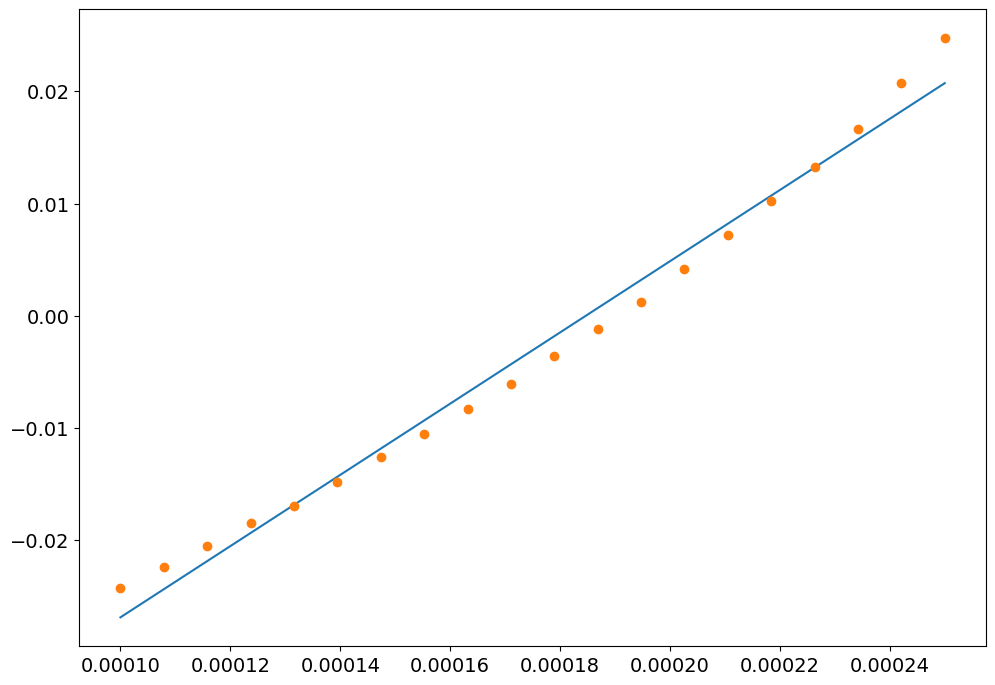

In [37]:
from scipy.optimize import curve_fit


path = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig3/fig3_normal_evencat/"
file_end = 'panther_normal_cat_decay_loop_evencat.h5'

thresholds = np.linspace(1e-4,2.5e-4, 20)
floor_values = []
for threshold in thresholds:
    x, y, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=threshold, plot=False)
    floor_values.append(data_array[0][0:5,:].mean())

from scipy.optimize import curve_fit

def line(x, m, y):
    return x*m+y
popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])

xvec, yvec, data_array, decay_times = load_triple_mask_decay(path, file_end ,thresh=thresh, plot=False)

#xvec = np.linspace(-1.7, 1.7, 69)
#plt.pcolormesh(x,x,data_array[0],vmin = -1, vmax = 1, cmap="seismic")

100%|██████████| 4761/4761 [00:44<00:00, 108.04it/s]
2975625it [00:52, 56201.99it/s]


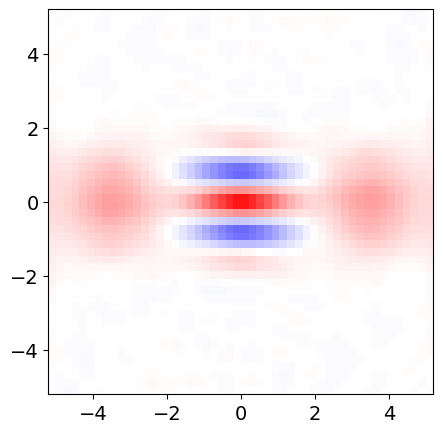

In [38]:
N = 25
vac_norm = 0.884
re_rho = reconstruct_dm(data_array[0]/vac_norm, x, N)
rho_tensor = tensor(qt.fock(2,0)*qt.fock(2,0).dag(),re_rho) 
plot_char(rho_tensor,max_alpha = 5.1)

In [39]:

alphas = np.linspace(1.7,1.9, 10)
cats = []
for  alpha in alphas:
    cat = ((displace(N,alpha) + displace(N, -alpha))*fock(N,0)).unit()
    cats.append(cat)

for cat in cats:
    print(expect(re_rho,cat))

0.7539777548807642
0.7555345454157384
0.7563293279967004
0.7563626496420034
0.7556370063137718
0.7541568447470351
0.7519285575841211
0.7489604711288363
0.7452628251588711
0.7408477443655237


In [7]:
55/60

0.9166666666666666